Loading decimated signal from /Users/ashaydwivedi/Documents/MATLAB/dsmadc_output.csv...
Using column: data
Loaded 251 samples at 2000.0 Hz
Detected tone frequency: 7.812500 Hz (bin 1)
Noise-floor:  SNR = 84.14 dB, ENOB = 13.68 bits

Noise density: -16.7 dBFS/Hz
Dynamic range (est): 46.7 dB


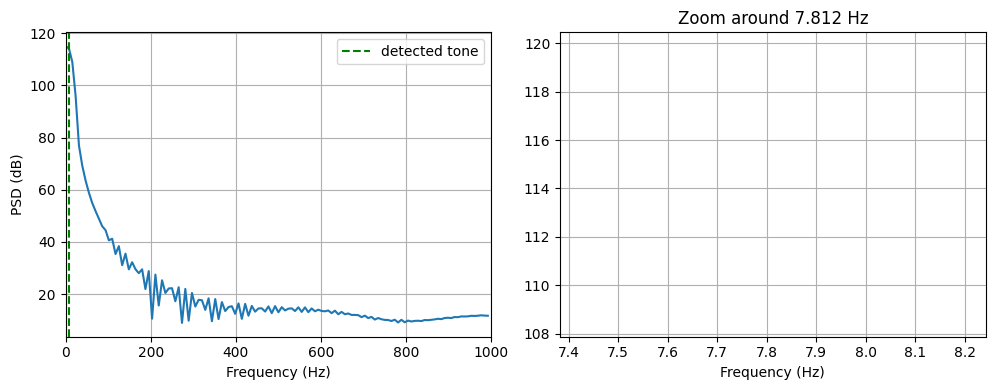

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import get_window
from numpy.fft import fft

csv_file = "./ENOB_in.csv"
Fs_target = 2000.0      # decimated sampling rate in Hz
fullscale = 1.0    
min_samples_warning = 4096

print(f"Loading decimated signal from {csv_file}...")
df = pd.read_csv(csv_file)

decimated = None
for col in df.columns:
    col_num = pd.to_numeric(df[col], errors='coerce').to_numpy()
    if np.all(np.isfinite(col_num)) and len(col_num) > 1:
        dif = np.diff(col_num)
        # reject strict monotonic column (likely time)
        if not (np.all(dif > 0) or np.all(dif < 0)):
            decimated = col_num.astype(float)
            print(f"Using column: {col}")
            break

if decimated is None:
    raise ValueError("No suitable (non-time) numeric column found in CSV. Check file.")

N_dec = len(decimated)
print(f"Loaded {N_dec} samples at {Fs_target} Hz")

if N_dec < min_samples_warning:
    print(f"WARNING: only {N_dec} samples (<{min_samples_warning}). ENOB estimates for 20-bit targets will be unreliable.")

# Remove DC component
decimated = decimated - np.mean(decimated)

if fullscale != 1.0:
    decimated = decimated / fullscale
    print(f"Data normalized by fullscale={fullscale} for dBFS reporting.")

# Windowing + FFT
beta = 10
window = get_window(('kaiser', beta), N_dec)
xw = decimated * window

NFFT = int(2 ** np.ceil(np.log2(N_dec)))
X = fft(xw, NFFT)
Pxx = (np.abs(X[:NFFT//2])**2) / (np.sum(window**2))   # relative power per bin
f = (np.arange(0, NFFT//2) * (Fs_target / NFFT))

# Auto detect largest tone (non DC)
search_bins = np.arange(1, len(Pxx))
sig_bin = search_bins[np.argmax(Pxx[search_bins])]
f_sig = f[sig_bin]
print(f"Detected tone frequency: {f_sig:.6f} Hz (bin {sig_bin})")

# ENOB / SNR Calculations
sig_bins = np.arange(max(sig_bin-7, 0), min(sig_bin+6, len(Pxx)))
signal_power = np.sum(Pxx[sig_bins])
noise_bins = np.setdiff1d(np.arange(1, len(Pxx)), sig_bins)
noise_power = np.sum(Pxx[noise_bins])

noise_floor = np.median(Pxx[noise_bins])
effective_noise_power = noise_floor * len(noise_bins)
SNR = 10*np.log10(signal_power / effective_noise_power)
ENOB = (SNR - 1.76) / 6.02

# Define a Rough Dynamic Range
noise_density = 10*np.log10(noise_floor / (Fs_target/2))
dynamic_range = -noise_density + 10*np.log10(Fs_target/2)

# Print Results
print(f"Noise-floor:  SNR = {SNR:.2f} dB, ENOB = {ENOB:.2f} bits")
print(f"\nNoise density: {noise_density:.1f} dBFS/Hz")
print(f"Dynamic range (est): {dynamic_range:.1f} dB")

# Quick plots
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(f, 10*np.log10(Pxx)); plt.xlim(0, Fs_target/2)
plt.axvline(f_sig, color='g', linestyle='--', label='detected tone')
plt.xlabel('Frequency (Hz)'); plt.ylabel('PSD (dB)')
plt.legend(); plt.grid(True)

plt.subplot(1,3,2)
zoom = (f >= f_sig-5) & (f <= f_sig+5)
plt.plot(f[zoom], 10*np.log10(Pxx[zoom])); plt.xlabel('Frequency (Hz)')
plt.title(f"Zoom around {f_sig:.3f} Hz"); plt.grid(True)

plt.tight_layout()
plt.show()